# Read in the data

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

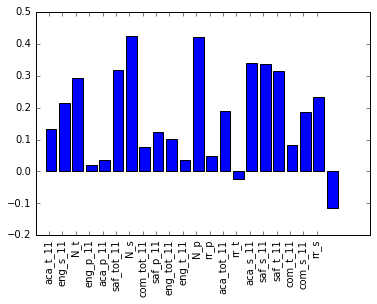

In [12]:
#grabs the overlapping fields from the survey fields and our combined data set
survey_sat_overlap = set(survey_fields).intersection(combined)
survey_sat_overlap = list(survey_sat_overlap)

#set up parameters for the bar graph
tick_positions = range(1,len(survey_sat_overlap))
bar_heights = correlations[survey_sat_overlap]
bar_positions = np.arange(len(bar_heights)) + 0.75
width = 0.8

#plot the graph
fig, ax = plt.subplots()
ax.bar(bar_positions, bar_heights, width)
ax.set_xticks(tick_positions)
ax.set_xticklabels(survey_sat_overlap, rotation = 90)



Strangely enough, we see a positive correlation between SAT score and Safety and Respect survery scores for both student and teacher, but the communication score has little correlation. Parent academic expectation has little to no correlation with the SAT score either. The number of students at the school seems to correlate as well.  Response rates all around seem to be correlated with higher SAT scores, which seems to suggest that higher involvement in the study represents higher SAT scores.

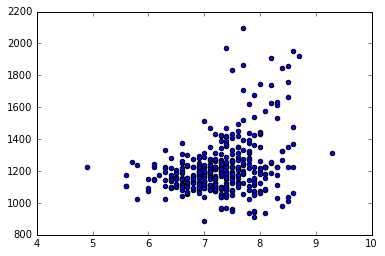

In [13]:
fig, ax = plt.subplots()
ax.scatter(combined['saf_tot_11'],combined['sat_score'])

There does seem to be a positive linear correlation between the safety scores and the SAT scores, especially in those with higher than 1600.

In [14]:
districts = combined.groupby("school_dist").agg(np.mean)
print(districts)




             SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
school_dist                                                         
01                                441.833333           473.333333   
02                                426.619092           444.186256   
03                                428.529851           437.997512   
04                                402.142857           416.285714   
05                                427.159915           438.236674   
06                                382.011940           400.565672   
07                                376.461538           380.461538   
08                                386.214383           395.542741   
09                                373.755970           383.582836   
10                                403.363636           418.000000   
11                                389.866667           394.533333   
12                                364.769900           379.109453   
13                                

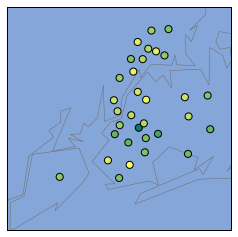

In [15]:
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
    )

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
    
longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(longitudes, latitudes, s=50, zorder = 2, latlon = True, c = districts["saf_tot_11"], cmap = "summer")
plt.show()

The map above seems to indicate that eastern parts of Brooklyn has the lowest safety scores and that the Bronx and Queens tends to have much higher safety scores.

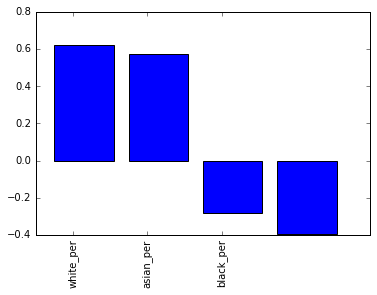

In [16]:
#grabs the overlapping fields from the survey fields and our combined data set
race_subset = ['white_per','asian_per','black_per','hispanic_per']

#set up parameters for the bar graph
tick_positions = range(1,len(race_subset))
bar_heights = correlations[race_subset]
bar_positions = np.arange(len(bar_heights)) + 0.75
width = 0.8

#plot the graph
fig, ax = plt.subplots()
ax.bar(bar_positions, bar_heights, width)
ax.set_xticks(tick_positions)
ax.set_xticklabels(race_subset, rotation = 90)


It seems like the hispanic student ratio is very negatively correlated with SAT scores, as well as a moderate negative correlation between the ratio of black students and SAT students. It's important to gauge the economic power of these demographics and see whether or not the SAT scores are correlated to the inherent race demographic or if they are simply more correlated to the race demographic's economic levels. Hispanic people might be doing poorer on the SAT simply because they tend to be more poor in New York City.

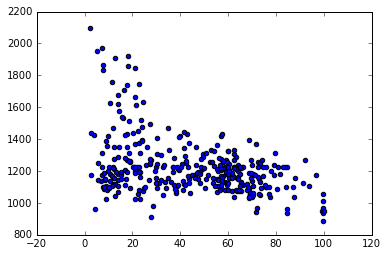

In [17]:
fig, ax = plt.subplots()
ax.scatter(combined['hispanic_per'],combined['sat_score'])

The graph seems to really indicate that the ratio of hispanic people in school correlates with decreasing SAT scores. Again to find out if this is racial bias or not, the english language learner percentage as well as hispanic people's relative economic status in these schools must be gauged.

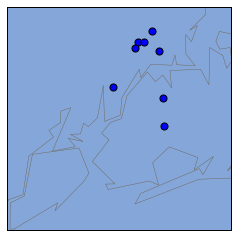

In [18]:
hisp_below10perc_schools = combined[combined["hispanic_per"] < 10]
hisp_above95perc_schools = combined[combined["hispanic_per"] > 95]

from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
    )

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
    
longitudes = hisp_above95perc_schools["lon"].tolist()
latitudes = hisp_above95perc_schools["lat"].tolist()

m.scatter(longitudes, latitudes, s=50, zorder = 2, latlon = True)
plt.show()

In [19]:
hisp_below10perc_schools = (combined[combined["hispanic_per"] < 10]['male_per'])
hisp_above95perc_schools = combined[combined["hispanic_per"] > 95]

hisp_below10perc_schools

37     59.3
46     51.3
151    57.8
187    58.3
192    49.0
194    46.1
220    61.7
223    53.8
226    50.1
227    51.6
228    52.0
229    61.6
230    63.3
231    53.0
235    41.8
236    23.8
237    49.0
238    61.0
240    64.3
241    48.9
242    47.4
280    50.7
327    56.5
330    56.0
331    53.3
332    56.9
335    55.1
337    42.8
353    49.6
356    57.0
Name: male_per, dtype: float64

All of the schools with a hispanic population above 95% tend to be international schools or schools aimed at educating first generation immigrants. On the flipside, hispanic populations above 10% tend to be more technical and prepatory high schools.

As far as location goes, the high schools with less than 10% Hispanic populations tend to be located in Brooklyn and Queens, while the ones with 95% plus population tend to be located in the Bronx.

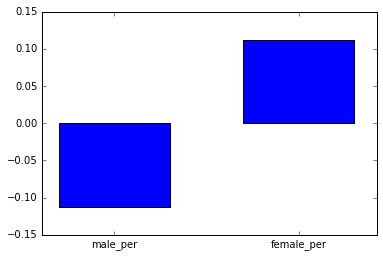

In [20]:
gender_subset = ['male_per','female_per']

#create the bar parameters 
bar_heights = correlations[gender_subset]
bar_positions = [0.33, 0.66]
width = 0.2

#create the barplot
fig, ax = plt.subplots()
ax.bar(bar_positions, bar_heights, width, align = 'center')
plt.xticks(bar_positions, gender_subset)
plt.show()

The correlations between gender ratio and SAT are pretty small in magnitude, suggesting that gender does not have much influence on SAT scores.
I'm surprised to see that there is a negative correlation between male_per and SAT_scores, given that we saw that the schools that had the smallest percentage of hispanic peoples (whose ratio had the biggest negative correlation with SAT scores out of the ones surveyed) were mostly technical schools, tended to have slightly more males. 

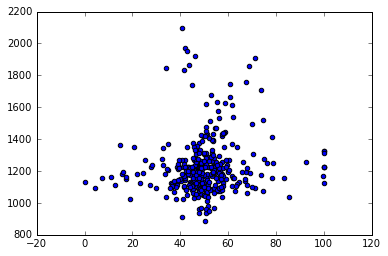

In [21]:
fig, ax = plt.subplots()
ax.scatter(combined['female_per'], combined['sat_score'])

There's no extremely clear trend in this graph. The large cluster in the middle suggests that most schools have approximately equal male and female populations.

In [22]:
high_performing_female_subset = np.all([[combined['sat_score'] > 1700], [combined['female_per'] > 60]], axis = 0).tolist()
high_performing_female_subset = high_performing_female_subset[0]
combined['school_name'][high_performing_female_subset]

5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object

Most of these high schools have college level courses that offer college credits, or are specialty prepatory schools.

A lot of these high performing schools are either performing art schools, college prep schools, or schools with focus in particular subjects/fields.

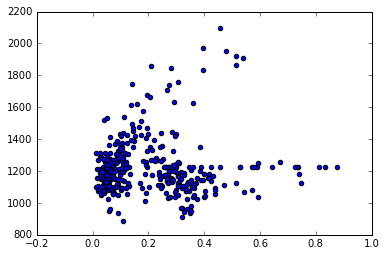

In [24]:
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"]
fig, ax = plt.subplots()
ax.scatter(combined["ap_per"], combined["sat_score"])

On one hand, there is a part of the population that seems to have the AP test and SAT scores correlated with each other, and then the other part seems to not